In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

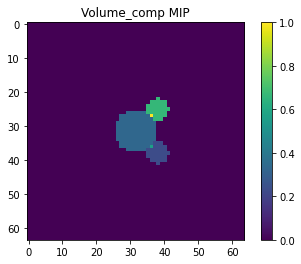

In [5]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

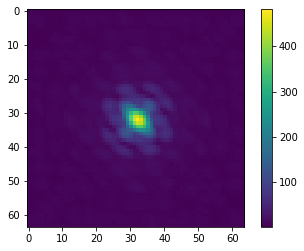

In [6]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

Get the grids and mask

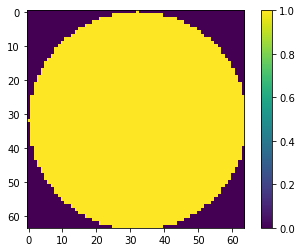

In [8]:
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

radius = 1.6
mask = create_mask(X, Y, Z , (0,0,0),radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

Generate projections (in Fourier domain)

In [56]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(mask * v, x_grid, y_grid, z_grid, angles)
    #projection, _ = project(v, x_grid, y_grid, z_grid, angles)

    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [251]:
img0 = slice_func(vol_fourier, [0,0,0])

N = 20000
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true) + (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0)
print(time.time()-start)

9.29820203781128


In [252]:
imgs.shape

(20000, 4096)

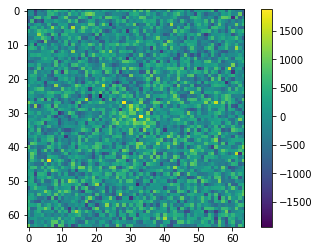

In [253]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[13].reshape(nx,nx)))); plt.colorbar()

In [254]:
np.sum(mask[0])

DeviceArray(3207., dtype=float64)

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [255]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img, alpha = 0.01):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    #return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles) - img))



@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

@jax.jit
def loss_func_sum(v, angles, imgs):
    return jnp.mean(loss_func_batched(v, angles, imgs))

In [197]:
loss_func(vol_fourier, angles_true[0],imgs[0])

DeviceArray(236630.43983906, dtype=float64)

And the gradients of the above, with respect to angles

In [256]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [93]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

1.3901700973510742
(1000,)


In [94]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

2.874378204345703
(3,)


In [95]:
#start = time.time()
#dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
#print(time.time()-start)
#print(dl.shape)

Gradients with respect to volume pixels, over all (or a batch of) images

In [257]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, imgs):
    return jax.grad(loss_func_sum)(v, angles, imgs)


In [97]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

0.9900877475738525
(128, 128, 128)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [98]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.3759057521820068
(128, 128, 128)


## Gradient descent with respect to angles

In [64]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = jnp.mod(a, 2*jnp.pi)
#a = angles_true + 0.01*a
N_iter = 1

for i in range(N_iter):
        
    if jnp.mod(i,100) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
a = jnp.mod(a, 2*jnp.pi)


    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 58239.96234931445
mean(a-a_true) = 2.084187294685684


In [ ]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

## Optimization with respect to volume

In [258]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 200
zero = jnp.zeros(vol_fourier.shape).astype(jnp.complex128)
Ab = - jnp.conj(grad_loss_volume_sum(zero, angles_true, imgs))
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles_true, imgs)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)


Iter 0 ||r|| = 0.24334166230813578
Iter 1 ||r|| = 0.09198429217565823
Iter 2 ||r|| = 0.04724475230710878
Iter 3 ||r|| = 0.03665552255081685
Iter 4 ||r|| = 0.0243406239088925
Iter 5 ||r|| = 0.016498060356289115
Iter 6 ||r|| = 0.011905421649250953
Iter 7 ||r|| = 0.00713638287034206
Iter 8 ||r|| = 0.0050400673697119334
Iter 9 ||r|| = 0.002816916868188728
Iter 10 ||r|| = 0.002085818954594709
Iter 11 ||r|| = 0.0030995820610025164
Iter 12 ||r|| = 0.0011781671290414816
Iter 13 ||r|| = 0.0008017905618971003
Iter 14 ||r|| = 0.000444693474882242
Iter 15 ||r|| = 0.0002732368620537555
Iter 16 ||r|| = 0.00019017073688997146
Iter 17 ||r|| = 0.00013815765261205925
Iter 18 ||r|| = 7.670917223296003e-05
Iter 19 ||r|| = 6.328163133677867e-05
Iter 20 ||r|| = 7.675330998129182e-05
Iter 21 ||r|| = 3.138166619063535e-05
Iter 22 ||r|| = 2.171363724641113e-05
Iter 23 ||r|| = 1.4755097559126664e-05
Iter 24 ||r|| = 8.99405719246389e-06
Iter 25 ||r|| = 7.1828133499860185e-06
Iter 26 ||r|| = 5.491186580043886e-06

In [259]:
jnp.max(jnp.abs(imgs))

DeviceArray(2994.68457432, dtype=float64)

Final loss function =  231699.31731886553
Relative error =  0.15760304160185618


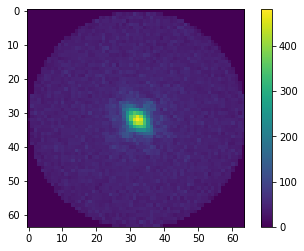

In [260]:
   
print("Final loss function = ", loss_func_sum(vcg, angles_true, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg - vol_fourier)/jnp.max(vol_fourier))))

mip_z(jnp.abs(jnp.fft.fftshift((vcg)))) ; plt.colorbar()

In [261]:
l = loss_func_batched(vcg, angles_true, imgs)

In [262]:
s0 = slice_func(vcg, angles_true[30])


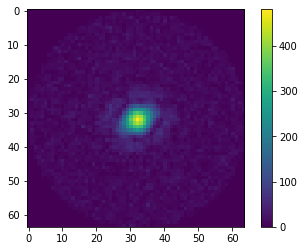

In [263]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

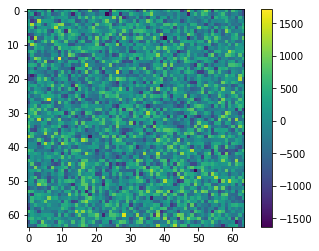

In [264]:
plt.imshow(jnp.fft.fftshift(jnp.imag(imgs[30]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

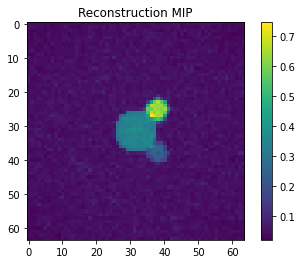

In [265]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

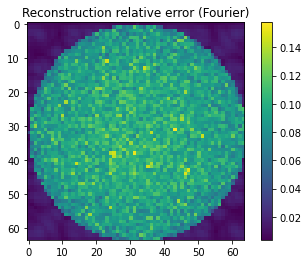

In [266]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

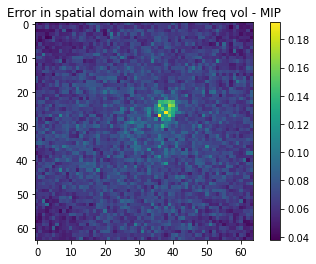

In [269]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vcg)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

In [270]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
#alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume with mask
alpha = 10000000
batch_size = 2
N_iter = 1000 * 20 
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 232900.68285959447
Iter 100: mean loss = 232443.52485520186
Iter 200: mean loss = 237797.16226751014
Iter 300: mean loss = 234284.60188515484
Iter 400: mean loss = 233054.4395372711
Iter 500: mean loss = 237888.8335456184
Iter 600: mean loss = 233556.19621196986
Iter 700: mean loss = 233350.81802612374
Iter 800: mean loss = 232436.9800804493
Iter 900: mean loss = 236585.26129435038
Iter 1000: mean loss = 230758.10827468475
Iter 1100: mean loss = 237641.06955936493
Iter 1200: mean loss = 234474.69552375126
Iter 1300: mean loss = 233156.15290749123
Iter 1400: mean loss = 230188.6675378186
Iter 1500: mean loss = 234739.92112618912
Iter 1600: mean loss = 236076.11964599526
Iter 1700: mean loss = 237048.0992318067
Iter 1800: mean loss = 237267.76351544418
Iter 1900: mean loss = 236007.7937501368
Iter 2000: mean loss = 230321.95335893898
Iter 2100: mean loss = 233671.6358178684
Iter 2200: mean loss = 240902.89315278007
Iter 2300: mean loss = 235636.49220371892
Iter 2400: 

In [271]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  235191.71441127153
Relative error =  0.9629793580632546


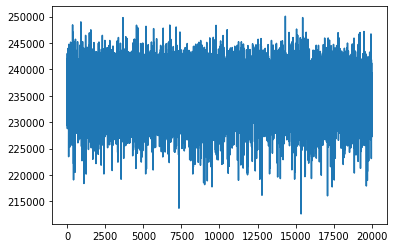

In [272]:
loss_imgs = loss_func_batched(v, angles_true, imgs)
plt.plot(loss_imgs)

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

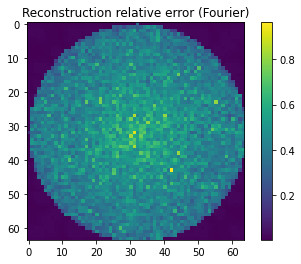

In [273]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

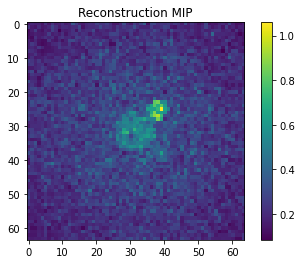

In [274]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

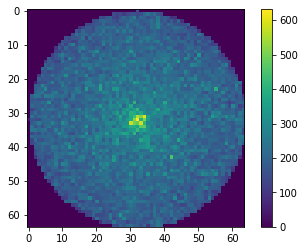

In [275]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

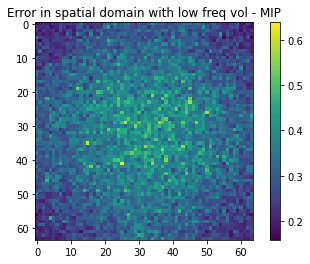

In [276]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

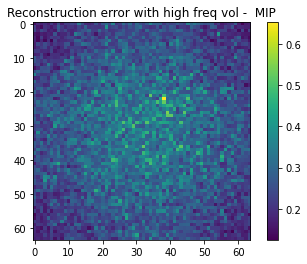

In [277]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

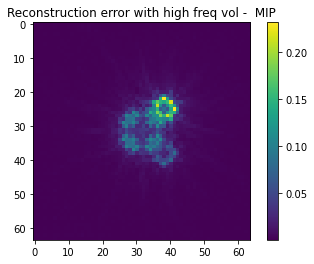

In [278]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')